In [424]:
import copy
import statistics

In [425]:
class Process:
    def __init__(this, name, arrival_time, execution_time, inturrpt_time, IOTime, priority):
        this.name = name
        this.arrival_time = arrival_time
        this.cpu_time = execution_time
        this.inturrpt_time = inturrpt_time
        this.IO_time = IOTime
        this.priority = priority
        this.tt = 0
        this.w = 0
    def __str__(this):
        return this.name
    def __repr__(this):
        return "<{}>".format(this.name)

In [430]:
#PN, AT, ET, IT, IOT, P
ps = """
P1 0 20.0 1.5 5.0 2
P2 2 15.0 2.0 6.0 1  
P3 6 27.0 1.8 3.5 4 
P4 4 36.0 2.1 2.6 3
"""

In [431]:
res = []
for proc in ps.split("\n"):
    p = proc.split(" ")
    p = list(filter(len, p))
    if p:
        p = p[:1] + list(map(float, p[1:]))
        res.append( Process(p[0], p[1], p[2], p[3], p[4], p[5]) )
        
print(res)

[<P1>, <P2>, <P3>, <P4>]


In [439]:
def sch_print(jobs, finished):
    print("#\tWaiting\tt(CPU)\tt(all)")
    jobs.sort(key=lambda p: p.name)
    for p in jobs:
        print(p, p.w, p.tt, p.tt+p.inturrpt_time+p.IO_time, sep="\t")

    print("\nAvg. cpu turnaround:", sum(p.tt for p in jobs)/len(jobs))
    print("Avg. total turnaround:", sum(p.tt+p.inturrpt_time+p.IO_time for p in jobs)/len(jobs))
    print("Stdv. cpu turnaround:", statistics.stdev(p.tt for p in jobs) )
    print("Stdv. total turnaround:", statistics.stdev(p.tt+p.inturrpt_time+p.IO_time for p in jobs) )
    print("Avg. wait:", sum(p.w for p in jobs) /len(jobs) )
    print("Stdv. wait:", statistics.stdev(p.w for p in jobs) )
    print("\nScheduling Order:")
    print(" ".join(p[0].name for p in finished))
    return (sum( (p.tt) for p in jobs)/len(jobs), sum(p.w for p in jobs)/len(jobs))

In [440]:
fcfs = [copy.deepcopy(p) for p in res]
fcfs = sorted(fcfs, key=lambda p: p.arrival_time)
fcfs_finished = []
ft = 0
for proc in fcfs:
    proc.w += ft - proc.arrival_time #waiting time
    ft = ft + proc.cpu_time #finish from cpu
    fcfs_finished.append( (proc, ft) )
    proc.tt += ft - proc.arrival_time


    
print("FCFS\n")
sch_print(fcfs, fcfs_finished)

FCFS

#	Waiting	t(CPU)	t(all)
P1	0.0	20.0	26.5
P2	18.0	33.0	41.0
P3	65.0	92.0	97.3
P4	31.0	67.0	71.69999999999999

Avg. cpu turnaround: 53.0
Avg. total turnaround: 59.125
Stdv. cpu turnaround: 32.69046751985457
Stdv. total turnaround: 31.66684649071749
Avg. wait: 28.5
Stdv. wait: 27.452990122510638

Scheduling Order:
P1 P2 P4 P3


(53.0, 28.5)

In [441]:
sjf = [copy.deepcopy(p) for p in res]
sjf = sorted(sjf, key=lambda p: (p.arrival_time, p.cpu_time))
sjf_arrv = sorted([p.arrival_time for p in sjf])
sjf_arrv.remove(0)
sjf_arrv


[2.0, 4.0, 6.0]

In [442]:
def sch_job(jobs, job, ct):
    if jobs and jobs[-1][0] == job: 
        jobs[-1] = (job, ct)
    else:
        jobs.append( (job, ct) )
        
def inc_wt(jobs, current_proc, time_amt, ct):
    for p in jobs:
        if p != current_proc and p.arrival_time <= ct and p.cpu_time:
            p.w += time_amt
    

In [443]:
ct = 0
proc = sjf[0]
finished = []
while(sjf_arrv):
    nat = sjf_arrv.pop(0)
    sch_job(finished, proc, ct)
    if(proc.cpu_time < (nat-ct) ):
        sjf_arrv = [nat] + sjf_arrv
        inc_wt(sjf, proc, proc.cpu_time, ct) #increse waiting time for other processes
        
        ct += proc.cpu_time
        proc.cpu_time = 0
        proc.tt = ct - proc.arrival_time
    else:
        inc_wt(sjf, proc, (nat - ct), ct)
        proc.cpu_time -= nat-ct
        ct = nat
    proc = min(filter(lambda p: p.arrival_time <= ct and p.cpu_time !=0, sjf), key=lambda p:p.cpu_time)




In [444]:
sjf = sorted(sjf, key=lambda p: p.cpu_time)
for proc in sjf:
    if not proc.cpu_time:continue
    
    sch_job(finished, proc, ct)
    ct += proc.cpu_time
    for p in sjf:
        if p.cpu_time and p!=proc:
            p.w += proc.cpu_time
    
    proc.tt = ct - proc.arrival_time 
    proc.cpu_time = 0




In [445]:
print("Preemptive SJF\n")
sch_print(sjf, finished)

Preemptive SJF

#	Waiting	t(CPU)	t(all)
P1	15.0	35.0	41.5
P2	0	15.0	23.0
P3	29.0	56.0	61.3
P4	58.0	94.0	98.69999999999999

Avg. cpu turnaround: 50.0
Avg. total turnaround: 56.125
Stdv. cpu turnaround: 33.77375707064091
Stdv. total turnaround: 32.406622265621365
Avg. wait: 25.5
Stdv. wait: 24.691429012243635

Scheduling Order:
P1 P2 P1 P3 P4


(50.0, 25.5)

In [446]:
#       RR
def inc_rr_wt(jobs, wt):
    #print(jobs, wt)
    for p in jobs:
        p.w += wt


def rr_sch(jobs, quantum):
    rr_jobs = [copy.deepcopy(p) for p in jobs]
    rr_jobs.sort(key=lambda p: (p.arrival_time, p.priority) )
    ct = 0
    finished = []
    proc_queue = [ rr_jobs[0] ]
    total_ex_time = sum(p.cpu_time for p in rr_jobs)
    while( proc_queue ):
        
        np = proc_queue.pop(0)
        sch_job(finished, np, ct)
        
        time_slice = min(quantum, np.cpu_time) #quantum/remaining cpu_time 
        inc_rr_wt(proc_queue, time_slice)
        ct += time_slice
        np.cpu_time -= time_slice
        
        
        for p in rr_jobs:
            if p != np and p.cpu_time and p.arrival_time <= ct and p not in proc_queue:
                p.w += ct - p.arrival_time
                proc_queue.append(p)
                
        
        if np.cpu_time:
            proc_queue.append(np)
        else:
            np.tt = ct - np.arrival_time
    
    print("RR\n")
    sch_print(rr_jobs, finished)
    return (sum( (p.tt) for p in rr_jobs)/len(rr_jobs), sum(p.w for p in rr_jobs)/len(rr_jobs))

In [447]:
rr_sch(res, 3)

RR

#	Waiting	t(CPU)	t(all)
P1	45	65.0	71.5
P2	37.0	52.0	60.0
P3	56.0	83.0	88.3
P4	58.0	94.0	98.69999999999999

Avg. cpu turnaround: 73.5
Avg. total turnaround: 79.625
Stdv. cpu turnaround: 18.663690238892556
Stdv. total turnaround: 17.226602489560534
Avg. wait: 49.0
Stdv. wait: 9.83192080250175

Scheduling Order:
P1 P2 P1 P4 P3 P2 P1 P4 P3 P2 P1 P4 P3 P2 P1 P4 P3 P2 P1 P4 P3 P1 P4 P3 P4 P3 P4 P3 P4 P3 P4


(73.5, 49.0)

In [409]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np



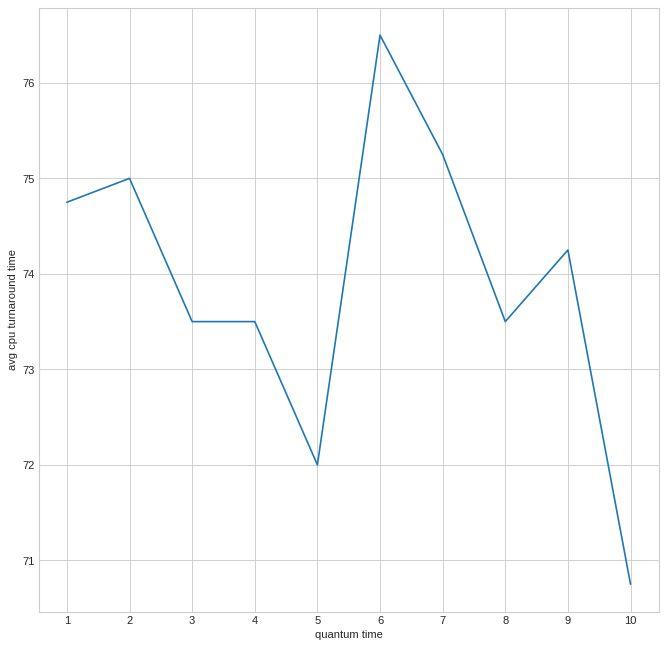

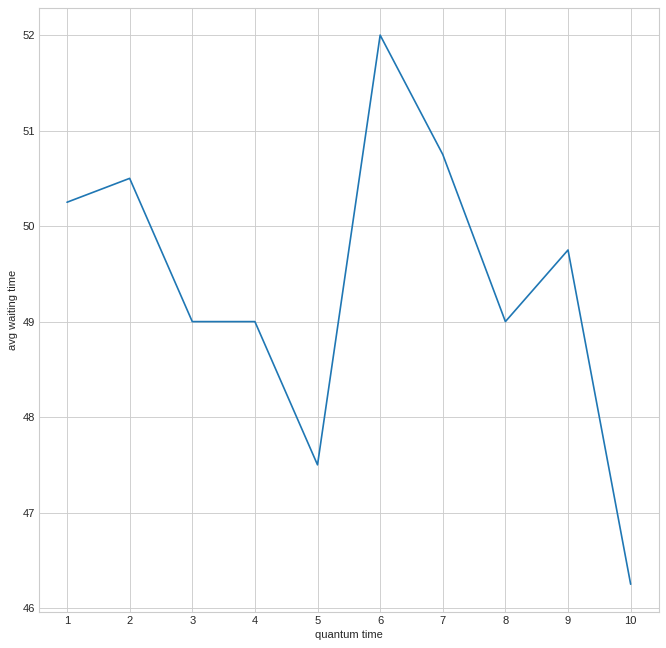

In [412]:
reslt = []
for i in range(1,11):
    reslt.append( rr_sch(res, i) )

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes()
x = range(1,11)
#y1 = [x[1] for x in reslt]
y2 = [x[0] for x in reslt]
plt.xlabel("quantum time")
plt.ylabel("avg cpu turnaround time");
plt.xticks( range(1,12) )
ax.plot(x, y2);


fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes()
x = range(1,11)
#y1 = [x[1] for x in reslt]
y2 = [x[1] for x in reslt]
plt.xlabel("quantum time")
plt.ylabel("avg waiting time");
plt.xticks( range(1,11) )
ax.plot(x, y2);

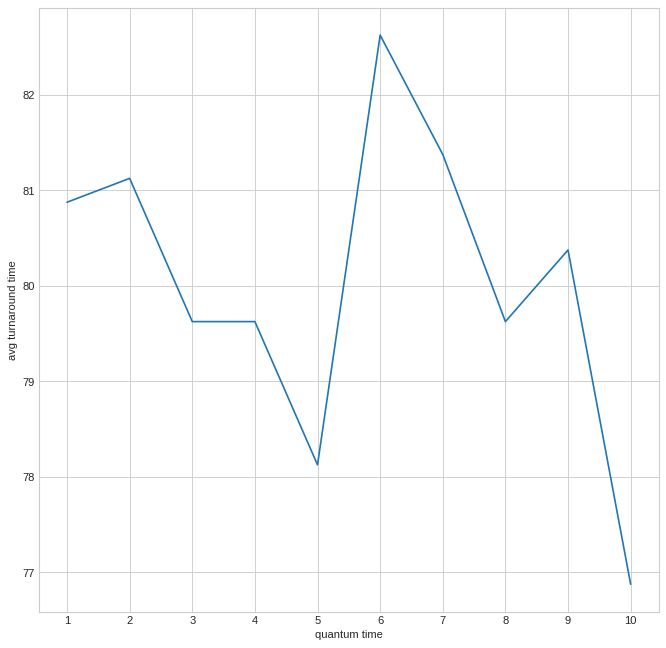

In [396]:
reslt = []
for i in range(1,11):
    reslt.append( rr_sch(res, i) )

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.axes()
x = range(1,11)
#y1 = [x[1] for x in reslt]
y2 = [x[0] for x in reslt]
plt.xlabel("quantum time")
plt.ylabel("avg turnaround time");
plt.xticks( range(1,12) )
ax.plot(x, y2);
